In [0]:
!unzip -qq /content/drive/My\ Drive/Colab\ Datasets/data_kaggle.zip -d dataset
# !unzip -qq /content/drive/My\ Drive/Colab\ Datasets/data_combined.zip -d dataset

In [2]:
# Pneumonia Prediction from X-Ray Images - Convolutional Neural Network (CNN)
# Using Kaggle datasets (training, validation and testing)

# Importing libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

Using TensorFlow backend.


In [0]:
hyper_dimension = 500
hyper_epochs = 100
hyper_batch_size = 16
hyper_feature_maps = 32
hyper_channels = 1
hyper_mode = 'grayscale'

In [0]:
# Initializing the CNN
classifier = Sequential()

# Convolution & Pooling - First convolution layer
classifier.add(Conv2D(hyper_feature_maps, (3, 3),
                      input_shape = (hyper_dimension,
                                     hyper_dimension,
                                     hyper_channels),
                      activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Convolution & Pooling - Second convolution layer (same as first layer)
classifier.add(Conv2D(hyper_feature_maps, (3, 3),
                      input_shape = (hyper_dimension,
                                     hyper_dimension,
                                     hyper_channels),
                      activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Convolution & Pooling - Third convolution layer
classifier.add(Conv2D(hyper_feature_maps * 2, (3, 3),
                      input_shape = (hyper_dimension,
                                     hyper_dimension,
                                     hyper_channels),
                      activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening
classifier.add(Flatten())

# Full Connection
classifier.add(Dense(units = hyper_feature_maps * 2, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam',
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])


In [5]:
# Creating Image Training and Validation Flows

train_gen = ImageDataGenerator(rescale = 1./255,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               vertical_flip = True)

val_gen = ImageDataGenerator(rescale = 1./255)

train_set = train_gen.flow_from_directory('/content/dataset/data_kaggle/train',
                                          target_size = (hyper_dimension,
                                                         hyper_dimension),
                                          batch_size = hyper_batch_size,
                                          class_mode = 'binary',
                                          color_mode = hyper_mode)

val_set = val_gen.flow_from_directory('/content/dataset/data_kaggle/val',
                                      target_size = (hyper_dimension,
                                                     hyper_dimension),
                                      batch_size = hyper_batch_size,
                                      class_mode = 'binary',
                                      color_mode = hyper_mode)

Found 4192 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


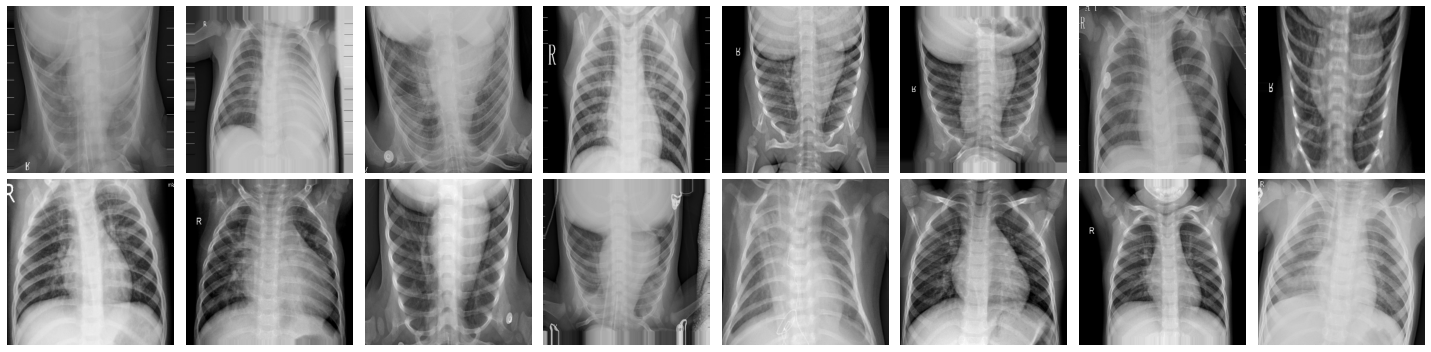

In [6]:
# Visualizing images in the first training set batch

image_batch = train_set[0][0]

plt.figure(figsize=(20,5))
for i in range(len(image_batch)):
    plt.subplot(2,8,i+1)
    pil_img = array_to_img(image_batch[i])
    plt.imshow(pil_img,cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
# Fitting the Model and Assessing Accuracy on the Validation Set

batch_size = hyper_batch_size

results = classifier.fit_generator(train_set,
                                   steps_per_epoch = len(train_set),
                                   epochs = hyper_epochs,
                                   validation_data = val_set,
                                   validation_steps = len(val_set))

Epoch 1/100
262/262 [==============================] - 145s 555ms/step - loss: 0.3597 - accuracy: 0.8421 - val_loss: 0.2197 - val_accuracy: 0.9240
Epoch 2/100
262/262 [==============================] - 138s 526ms/step - loss: 0.2196 - accuracy: 0.9172 - val_loss: 0.1263 - val_accuracy: 0.9452
Epoch 3/100
262/262 [==============================] - 138s 527ms/step - loss: 0.1926 - accuracy: 0.9241 - val_loss: 0.1564 - val_accuracy: 0.9510
Epoch 4/100
262/262 [==============================] - 138s 525ms/step - loss: 0.1725 - accuracy: 0.9301 - val_loss: 0.0772 - val_accuracy: 0.9538
Epoch 5/100
262/262 [==============================] - 138s 527ms/step - loss: 0.1661 - accuracy: 0.9351 - val_loss: 0.1737 - val_accuracy: 0.9452
Epoch 6/100
262/262 [==============================] - 138s 526ms/step - loss: 0.1748 - accuracy: 0.9287 - val_loss: 0.0973 - val_accuracy: 0.9452
Epoch 7/100
262/262 [==============================] - 141s 539ms/step - loss: 0.1583 - accuracy: 0.9380 - val_loss: 0

In [0]:
# Saving the model to JSON for further use

classifier_json = classifier.to_json()
with open("pneumonia_cnn_model.json", "w") as json_file:
    json_file.write(classifier_json)

# Saving the model weights for further use

classifier.save_weights('pneumonia_cnn_weights.h5')

In [9]:
# Creating Image Test Flow

test_gen = ImageDataGenerator(rescale = 1./255)

test_set = test_gen.flow_from_directory('/content/dataset/data_kaggle/test',
                                        target_size = (hyper_dimension,
                                                       hyper_dimension),
                                        batch_size = 1,
                                        class_mode = None,
                                        color_mode = hyper_mode,
                                        shuffle=False)

# Making Predictions

predictions = classifier.predict_generator(test_set)
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

Found 624 images belonging to 2 classes.


In [10]:
# Confusion Matrix

cm = pd.DataFrame(data=confusion_matrix(test_set.classes, predictions, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
cm

,Predicted Normal,Predicted Opacity
Actual Normal,178,56
Actual Opacity,3,387


In [11]:
print(f'Accuracy: {100*(cm[0][0]+cm[1][1])/cm.sum():.2f} %')

Accuracy: 90.54 %
